In [ ]:
!pip install torch-summary

In [1]:
import numpy as np
!pip install pydub
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
# copy this file to /usr/local/lib/python3.10/dist-packages/td_utils_c.py then import it
!cp "/content/drive/MyDrive/Colab Notebooks/my-Trigger-Word-Detection/td_utils_c.py" "/usr/local/lib/python3.10/dist-packages/td_utils_c.py"
from td_utils_c import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

NameError: ignored

In [ ]:
x = graph_spectrogram("/content/drive/MyDrive/Colab Notebooks/Keras-Trigger-Word/audio_examples/example_train.wav")

FileNotFoundError: ignored

In [ ]:
print(x.T.shape)

(5511, 101)


In [3]:
# Use 1101 for 2sec input audio
Tx = 1198 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram
# Use 272 for 2sec input audio
Ty = 296# The number of time steps in the output of our model

## Loading the model we trained before

In [4]:
import torch
from torch import nn
!pip install torch-summary
from torchsummary import summary

## loading the model

In [6]:
class TW_model(nn.Module):

    def __init__(self, input_channels, conv_out,hidden_size, dropout_prob):
        super(TW_model, self).__init__()

        self.conv_layer_0 = nn.Conv1d(input_channels, conv_out, kernel_size=15, stride=4)
        self.batch_norm_layer_0 = nn.BatchNorm2d(num_features=conv_out)
        self.relu_0 = nn.ReLU()
        self.dropout_layer_0 = nn.Dropout(p=dropout_prob)

        self.gru_layer_1 = nn.GRU(conv_out, hidden_size, batch_first=True)
        self.dropout_layer_1 = nn.Dropout(p=dropout_prob)
        self.batch_norm_layer_1 = nn.BatchNorm2d(hidden_size)

        self.gru_layer_2 = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout_layer_2_0 = nn.Dropout(p=dropout_prob)
        self.batch_norm_layer_2 = nn.BatchNorm2d(hidden_size)
        self.dropout_layer_2_1 = nn.Dropout(p=dropout_prob)

        self.dense_3 = nn.Linear(in_features=hidden_size, out_features=1)
        self.sigmoid_3 = nn.Sigmoid()


    def forward(self, x):
        x = x.reshape(n_freq,Tx)

        x = self.conv_layer_0(x)

        x = x.reshape(1, 1,x.shape[1],x.shape[0])
        x = x.permute(0, 3, 1, 2)
        x = self.batch_norm_layer_0(x)
        x = self.relu_0(x)
        x = self.dropout_layer_0(x)
        # print(f'\n3-: {x.shape}')
        x=x.reshape(1,x.shape[3],x.shape[1])
        x,_ = self.gru_layer_1(x)
        x = self.dropout_layer_1(x)
        x = x.reshape(1, 1,x.shape[1],x.shape[2])
        x = x.permute(0, 3, 1, 2)
        x = self.batch_norm_layer_1(x)
        # print(f'\n5-: {x.shape}')
        x=x.reshape(1,x.shape[3],x.shape[1])
        x,_ = self.gru_layer_2(x)
        x = self.dropout_layer_2_0(x)
        x = x.reshape(1, 1,x.shape[1],x.shape[2])
        x = x.permute(0, 3, 1, 2)
        x = self.batch_norm_layer_2(x)
        x = self.dropout_layer_2_1(x)
        x = x.reshape(1, 1,x.shape[3],x.shape[1])
        x = self.dense_3(x)
        output = self.sigmoid_3(x)
        return output
model = TW_model(input_channels=n_freq,conv_out=196,hidden_size=128,dropout_prob=0.8)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/my-Trigger-Word-Detection/TWDetection_model_cpu (4).pt', map_location='cpu'))

<All keys matched successfully>

In [8]:
!pip install torchviz
import torchviz
from torchviz import make_dot
make_dot(predict, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=9bc93cbf094326e4e8275941aea3af8ede6228e6d54f0d3a96d72184c998cb55
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


KeyboardInterrupt: ignored

In [9]:
from torchviz import make_dot
make_dot(predict, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

KeyboardInterrupt: ignored

In [ ]:
summary(model,input_data=x)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 296]                 297,136
├─BatchNorm2d: 1-2                       [-1, 196, 1, 296]         392
├─ReLU: 1-3                              [-1, 196, 1, 296]         --
├─Dropout: 1-4                           [-1, 196, 1, 296]         --
├─GRU: 1-5                               [-1, 296, 128]            125,184
├─Dropout: 1-6                           [-1, 296, 128]            --
├─BatchNorm2d: 1-7                       [-1, 128, 1, 296]         256
├─GRU: 1-8                               [-1, 296, 128]            99,072
├─Dropout: 1-9                           [-1, 296, 128]            --
├─BatchNorm2d: 1-10                      [-1, 128, 1, 296]         256
├─Dropout: 1-11                          [-1, 128, 1, 296]         --
├─Linear: 1-12                           [-1, 1, 296, 1]           129
├─Sigmoid: 1-13                          [-1, 1, 296, 1]           

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 296]                 297,136
├─BatchNorm2d: 1-2                       [-1, 196, 1, 296]         392
├─ReLU: 1-3                              [-1, 196, 1, 296]         --
├─Dropout: 1-4                           [-1, 196, 1, 296]         --
├─GRU: 1-5                               [-1, 296, 128]            125,184
├─Dropout: 1-6                           [-1, 296, 128]            --
├─BatchNorm2d: 1-7                       [-1, 128, 1, 296]         256
├─GRU: 1-8                               [-1, 296, 128]            99,072
├─Dropout: 1-9                           [-1, 296, 128]            --
├─BatchNorm2d: 1-10                      [-1, 128, 1, 296]         256
├─Dropout: 1-11                          [-1, 128, 1, 296]         --
├─Linear: 1-12                           [-1, 1, 296, 1]           129
├─Sigmoid: 1-13                          [-1, 1, 296, 1]           

In [7]:
x = torch.randn(Tx,n_freq)
predict = model(x)
print(predict.shape)

torch.Size([1, 1, 296, 1])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
def detect_tw(filename):
  x = graph_spectrogram(filename)
  print(x.shape)
  x = torch.from_numpy(x)
  print(x.dtype)
  x = x.to(device=device,dtype=torch.float32)
  print(x.device)
  prediction = model(x)
  return prediction

(101, 1198)
torch.float64
cuda:0
296


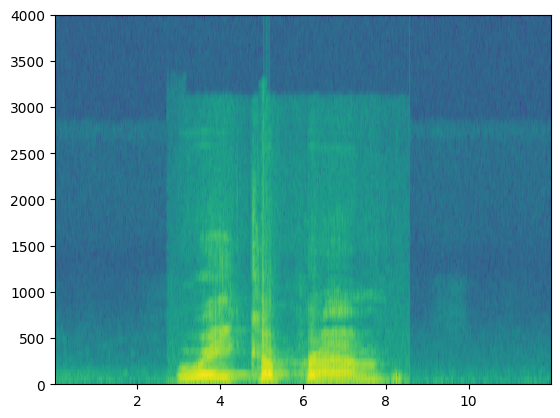

In [ ]:
sample = detect_tw('/content/drive/MyDrive/Colab Notebooks/my-Trigger-Word-Detection/train.wav')
print(sample.shape[2])

In [ ]:
chime_file = "/content/drive/MyDrive/Colab Notebooks/my-Trigger-Word-Detection/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[2]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,0,i,0] > threshold and consecutive_timesteps > 75:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0

    audio_clip.export("chime_output.wav", format='wav')

(101, 1198)
torch.float64
cuda:0


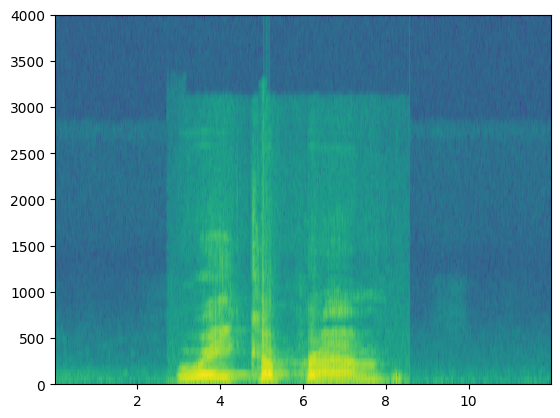

In [ ]:
# filename = "/content/drive/MyDrive/Colab Notebooks/Keras-Trigger-Word/raw_data/dev/1.wav"
filename = "/content/drive/MyDrive/Colab Notebooks/my-Trigger-Word-Detection/train.wav"
prediction = detect_tw(filename)
chime_on_activate(filename, prediction,0.7)
IPython.display.Audio("./chime_output.wav")